для игнорирования предупреждений

In [1]:
import warnings
warnings.filterwarnings('ignore')

##  Обучение с учителем. Классификация. Функция риска. Логистическая регрессия. Feature selection и extraction.


In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from matplotlib.colors import ListedColormap
from sklearn import datasets, linear_model, metrics # cross_validation, 

In [101]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing

In [102]:
# red_wine = pd.read_csv('winequality-red.csv', sep=";")
# red_wine['Type'] = 'red'
# white_wine = pd.read_csv('winequality-white.csv', sep=";")
# white_wine['Type'] = 'white'
# wine_data = pd.concat([red_wine, white_wine], axis=0)
# wine_data_shuffle = wine_data.sample(frac=1).reset_index(drop=True)
# wine_data_shuffle.to_csv('wine_data.csv', index=False, sep='\t')

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. Decision Support Systems, 47(4):547-553, 2009: имеются оценки качества 6497 португальских вин Vinho Verde, выставленные дегустаторами при слепом тестировании в баллах по шкале от 0 до 10.

Прочитаем данные:

In [5]:
path = './wine_data.csv' #'D:/wine_data.csv'
wine = pd.read_csv(path, sep='\t') # header=0
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Type
0,7.6,0.95,0.03,2.0,0.090,7.0,20.0,0.99590,3.20,0.56,9.6,5,red
1,7.6,0.32,0.36,1.6,0.040,32.0,155.0,0.99300,3.23,0.52,11.3,6,white
2,7.0,0.12,0.29,10.3,0.039,41.0,98.0,0.99564,3.19,0.38,9.8,8,white
3,6.6,0.61,0.01,1.9,0.080,8.0,25.0,0.99746,3.69,0.73,10.5,5,red
4,7.8,0.34,0.27,1.2,0.040,25.0,106.0,0.99320,3.01,0.55,10.4,5,white


In [6]:
wine.Type[wine.Type=='red']=1
wine.Type[wine.Type=='white']=0

Сделаем классификацию на два класса. Будем считать вино с рейтингом 7 или больше хорошим. Сделаем даже отдельный столбец $IsGood$, показывающий, является ли вино хорошим. Посмотрим, как теперь выглядят наши данные.

In [7]:
wine['IsGood'] = wine['quality'].apply(lambda x: "Yes" if x >= 7 else "No")
wine = wine.drop(['quality'], axis=1)
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Type,IsGood
0,7.6,0.95,0.03,2.0,0.090,7.0,20.0,0.99590,3.20,0.56,9.6,1,No
1,7.6,0.32,0.36,1.6,0.040,32.0,155.0,0.99300,3.23,0.52,11.3,0,No
2,7.0,0.12,0.29,10.3,0.039,41.0,98.0,0.99564,3.19,0.38,9.8,0,Yes
3,6.6,0.61,0.01,1.9,0.080,8.0,25.0,0.99746,3.69,0.73,10.5,1,No
4,7.8,0.34,0.27,1.2,0.040,25.0,106.0,0.99320,3.01,0.55,10.4,0,No


Прежде всего, посмотрим, как распределена зависимая переменная. Из первого графика видно, что подавляющее большинство значений – нули. Скорее всего для реальных задач будет необходимо пользоваться методами овер/андерсемплинг, чтобы избежать подобного перекоса в данных и более точно предсказывать интересующую переменную.

### разобьём данные для преобразований, используем StratifiedKFold для равномерной разбивки

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
train_index, test_index = next(ss.split(wine.drop(['IsGood'], axis=1), wine.IsGood))

In [9]:
train_index

array([  34, 4835, 2961, ..., 1724, 3192,  735])

In [69]:
wine_train = pd.DataFrame(np.array(wine)[train_index], columns=wine.columns)
wine_test = pd.DataFrame(np.array(wine)[test_index], columns=wine.columns)

In [70]:
wine_train.dtypes

fixed acidity           object
volatile acidity        object
citric acid             object
residual sugar          object
chlorides               object
free sulfur dioxide     object
total sulfur dioxide    object
density                 object
pH                      object
sulphates               object
alcohol                 object
Type                    object
IsGood                  object
dtype: object

In [71]:
for col in wine.columns:
    wine_train[col] = wine_train[col].astype(dtype="float32") if col not in ["Type", "IsGood"] else wine_train[col].astype(dtype="object")
    wine_test[col] = wine_test[col].astype(dtype="float32") if col not in ["Type", "IsGood"] else wine_test[col].astype(dtype="object")

In [72]:
wine_train.dtypes

fixed acidity           float32
volatile acidity        float32
citric acid             float32
residual sugar          float32
chlorides               float32
free sulfur dioxide     float32
total sulfur dioxide    float32
density                 float32
pH                      float32
sulphates               float32
alcohol                 float32
Type                     object
IsGood                   object
dtype: object

Text(0.5, 1.0, 'Распределение зависимой переменной')

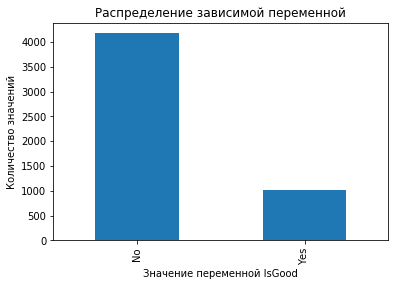

In [14]:
wine_train['IsGood'].value_counts().plot(kind='bar')
plt.xlabel('Значение переменной IsGood')
plt.ylabel('Количество значений')
plt.title('Распределение зависимой переменной')

In [15]:
wine_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000
mean,7.226313,0.340717,0.318645,5.434607,0.055892,30.591206,115.067924,0.994695,3.217401,0.531003,10.495772
std,1.299779,0.165144,0.146876,4.731494,0.034504,18.022955,56.938530,0.002954,0.162113,0.149363,1.189976
min,4.200000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,17.000000,76.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994900,3.210000,0.510000,10.300000
75%,7.700000,0.410000,0.390000,8.100000,0.065000,42.000000,155.000000,0.996990,3.320000,0.600000,11.300000
max,15.600000,1.580000,1.660000,31.600000,0.611000,289.000000,440.000000,1.010300,4.010000,2.000000,14.200000


Посмотрим на распределение непрерывных признаков.

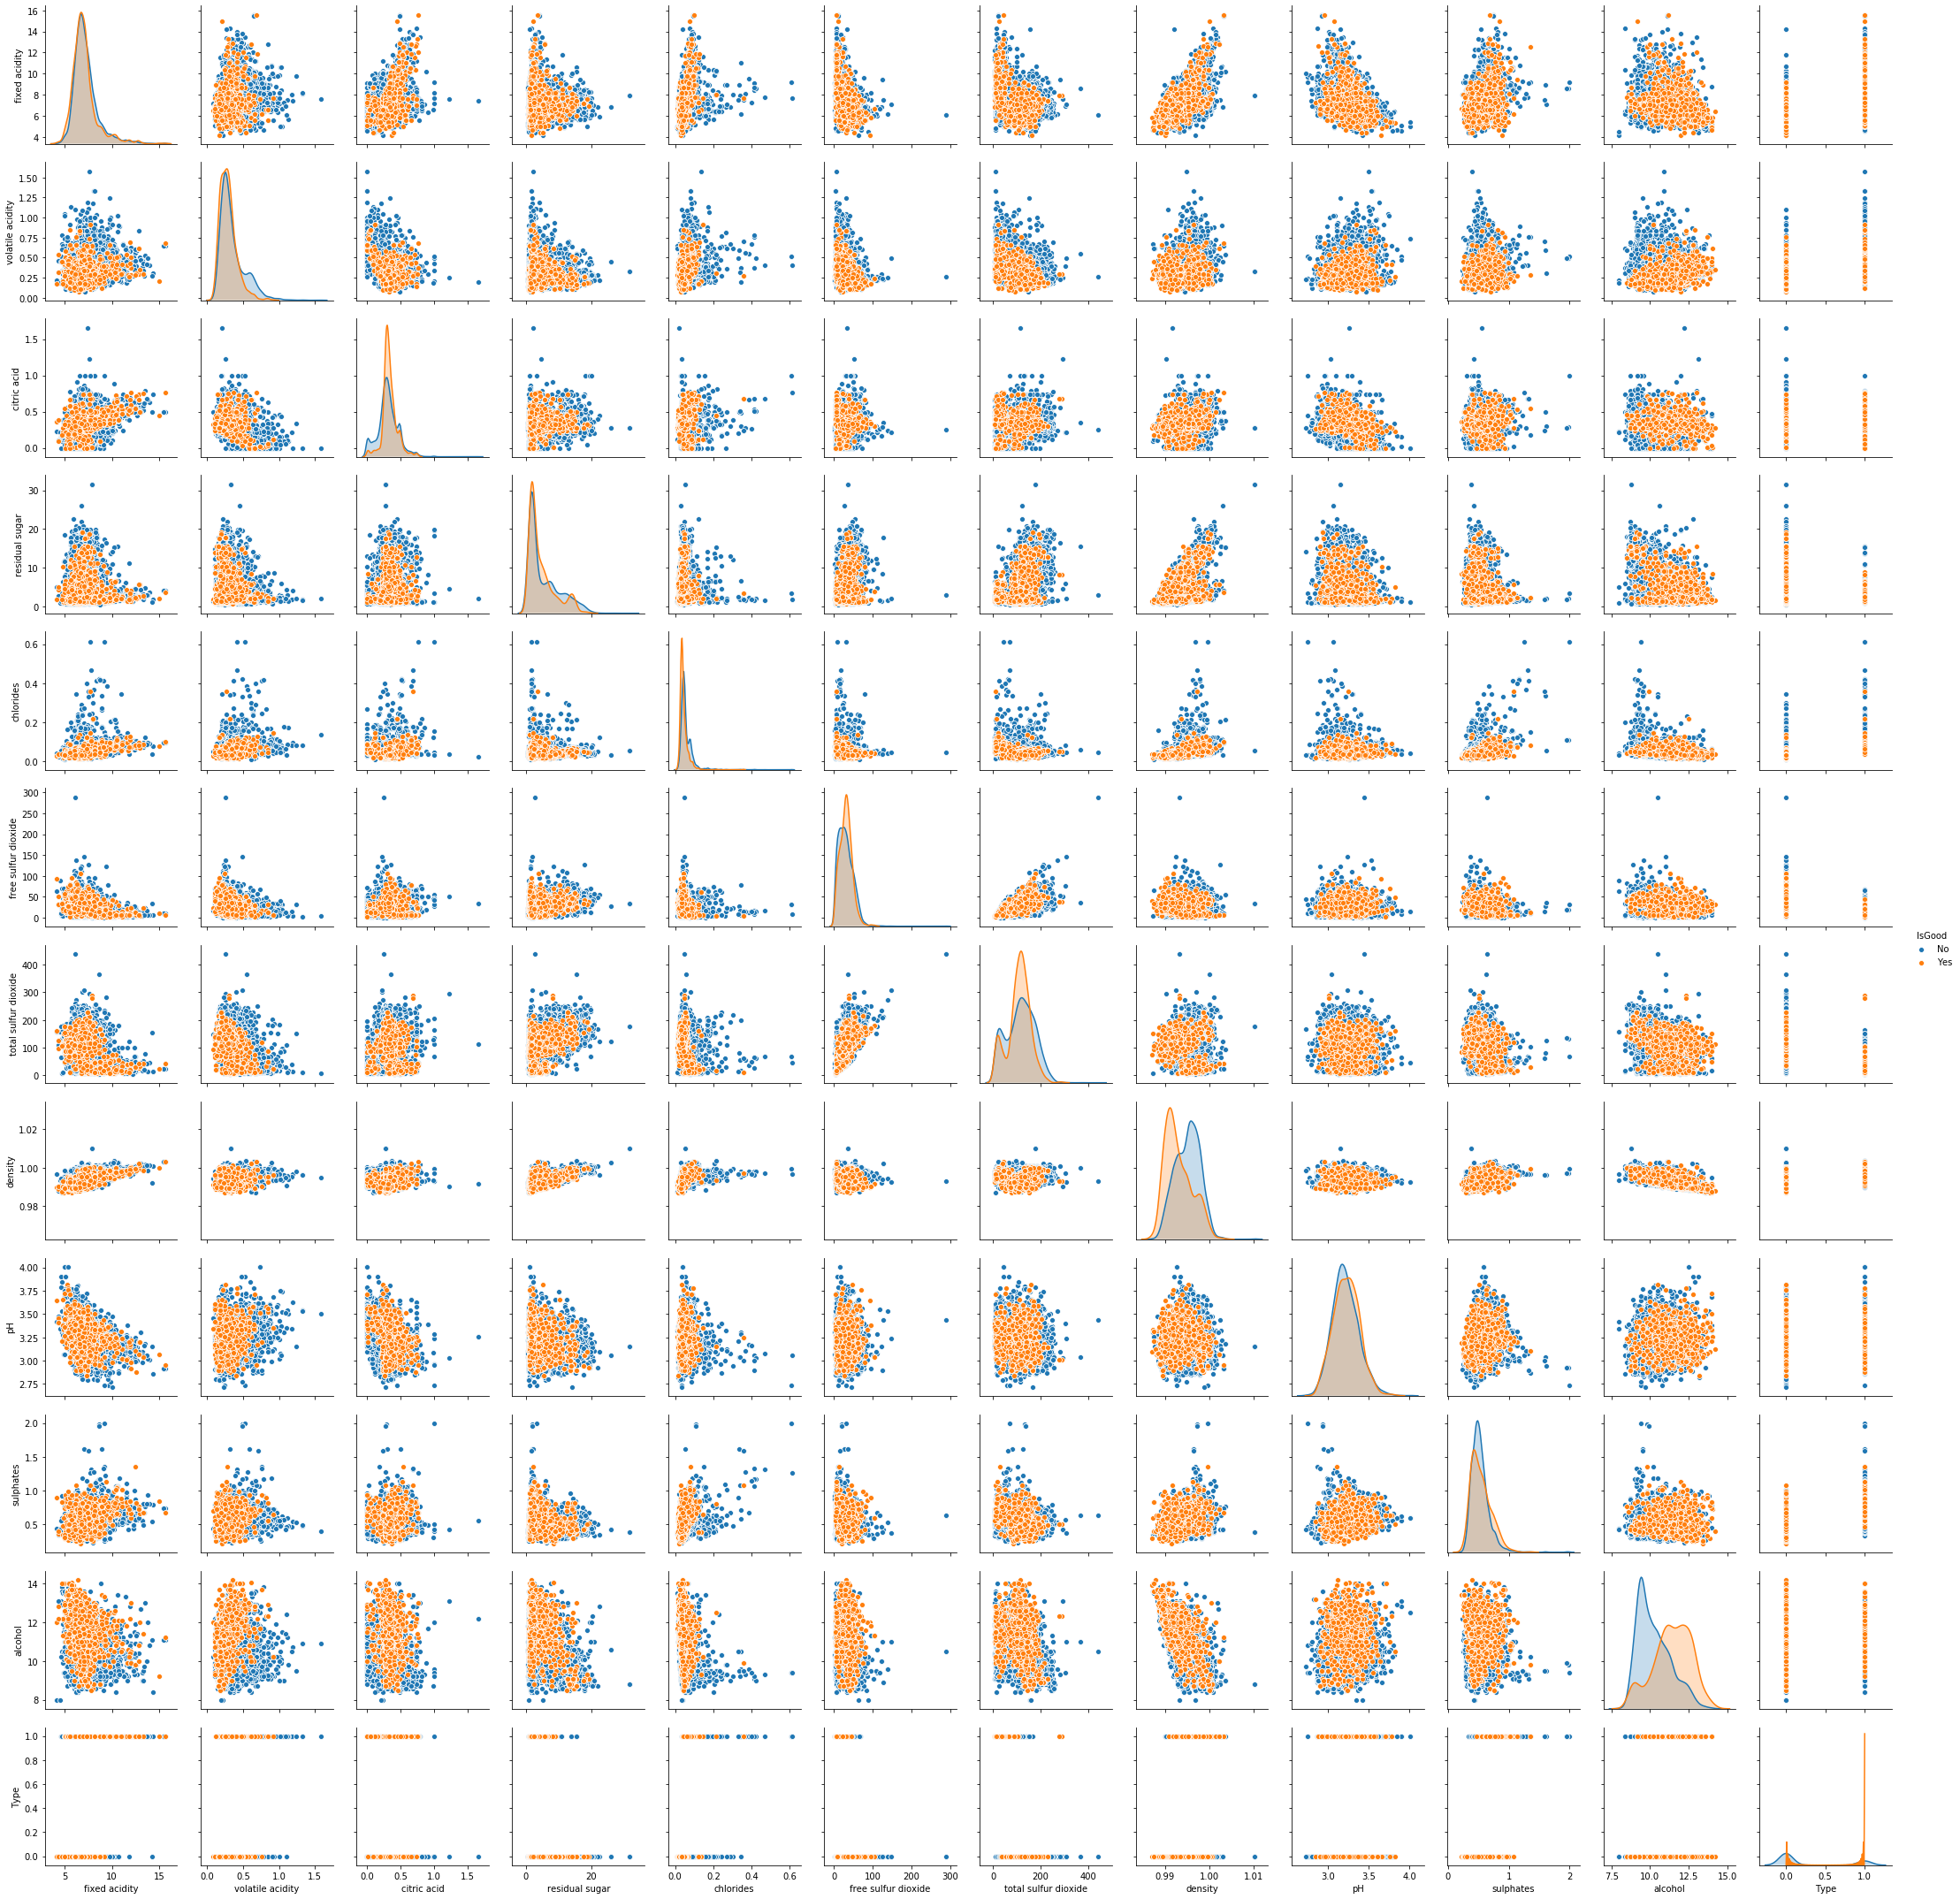

In [16]:
sns.pairplot(wine_train, hue='IsGood')

Из графика можно увидеть, что распределения некоторых признаков сильно несимметричные, поэтому в дальнейшим прологарифмируем.

Корреляция между независимыми переменными нам не так интересна, а корреляция независимых переменных с $IsGood$ может быть полезна для дальнейшего анализа (например, выделения релевантных признаков). 

In [73]:
wine_train['IsGood'] = wine_train['IsGood'].apply(lambda x: 0 if x is "No" else 1).astype('int16')
wine_test['IsGood'] = wine_test['IsGood'].apply(lambda x: 0 if x is "No" else 1).astype('int16')

In [74]:
wine_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Type,IsGood
0,1.945910,0.277632,0.262364,2.116256,0.160417,3.850147,159.0,0.99519,3.18,0.398776,9.4,0,0
1,2.484907,0.182322,0.392042,1.098612,0.294906,1.945910,18.0,0.99790,3.30,0.536493,10.5,1,0
2,2.360854,0.254642,0.378436,0.896088,0.038259,4.363099,223.0,0.99440,2.92,0.378436,9.5,0,0
3,1.902107,0.307485,0.292670,1.648659,0.025668,3.091043,77.0,0.99070,3.41,0.371564,11.9,0,0
4,2.028148,0.182322,0.131028,1.686399,0.168899,3.583519,168.0,0.99396,2.93,0.371564,9.4,0,0


In [75]:
wine_train.dtypes

fixed acidity           float32
volatile acidity        float32
citric acid             float32
residual sugar          float32
chlorides               float32
free sulfur dioxide     float32
total sulfur dioxide    float32
density                 float32
pH                      float32
sulphates               float32
alcohol                 float32
Type                     object
IsGood                    int16
dtype: object

In [76]:
correlated_features = ['IsGood'] + list(wine_train.corr().loc['IsGood'].abs().sort_values(ascending=False).iloc[1:11].index)
sub_df = wine_train[correlated_features]
sub_df.corr().iloc[0,1:]

alcohol                 0.392071
density                -0.279784
chlorides              -0.168367
volatile acidity       -0.145342
citric acid             0.069259
fixed acidity          -0.055279
total sulfur dioxide   -0.050484
residual sugar         -0.047356
free sulfur dioxide     0.043171
sulphates               0.041347
Name: IsGood, dtype: float64

Чтобы выбрать какие признаки логарифмировать посмотрим эксцесс и асимметрию.  
Как известно для нормальности распределения величины этих показателей должны быть около 0.

In [77]:
from scipy.stats import kurtosis
from scipy.stats import skew

In [78]:
for i in wine_train.columns:
    print(f"{i}:\n kurtosis = {kurtosis(wine_train[i])} skew = {skew(wine_train[i])}")

fixed acidity:
 kurtosis = 2.1194338068794085 skew = 1.0131382942199707
volatile acidity:
 kurtosis = 1.2251847958748074 skew = 1.1320726871490479
citric acid:
 kurtosis = 1.104562800574855 skew = -0.04895036295056343
residual sugar:
 kurtosis = -1.1740688126761192 skew = 0.42465612292289734
chlorides:
 kurtosis = 36.5262485435446 skew = 4.481998443603516
free sulfur dioxide:
 kurtosis = 0.09036460619973807 skew = -0.7222191095352173
total sulfur dioxide:
 kurtosis = -0.390724560905753 skew = -0.0057129403576254845
density:
 kurtosis = -0.49738635955486243 skew = 0.024469321593642235
pH:
 kurtosis = 0.41598951203796064 skew = 0.39242950081825256
sulphates:
 kurtosis = 3.3159607288427075 skew = 1.0956957340240479
alcohol:
 kurtosis = -0.5515346410041744 skew = 0.5559486746788025
Type:
 kurtosis = -0.6522314107842253 skew = 1.1609343604250648
IsGood:
 kurtosis = 0.33460007467699526 skew = 1.5279398138267737


Выберем необходимые признаки

Прологарифмируем те переменные, где сильные отклонения на трейне. Помним, что оба параметра для нормального распределения нули.

In [105]:
numeric_feats = wine.dtypes[(wine.dtypes != "object") & (wine.dtypes != "int16")].index

skewed_feats = wine_train[numeric_feats].apply(lambda x: skew(x.dropna()))
kurtosis_feats = wine_train[numeric_feats].apply(lambda x: kurtosis(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
kurtosis_feats = kurtosis_feats[kurtosis_feats > 0.75]
kurtosis_feats = kurtosis_feats.index
skewed_feats = skewed_feats.index
feats = list(set(list(kurtosis_feats) + list(skewed_feats)))

wine_train[feats] = np.log1p(wine_train[feats])
wine_test[feats] = np.log1p(wine_test[feats])

In [80]:
feats

['chlorides', 'volatile acidity', 'citric acid', 'fixed acidity', 'sulphates']

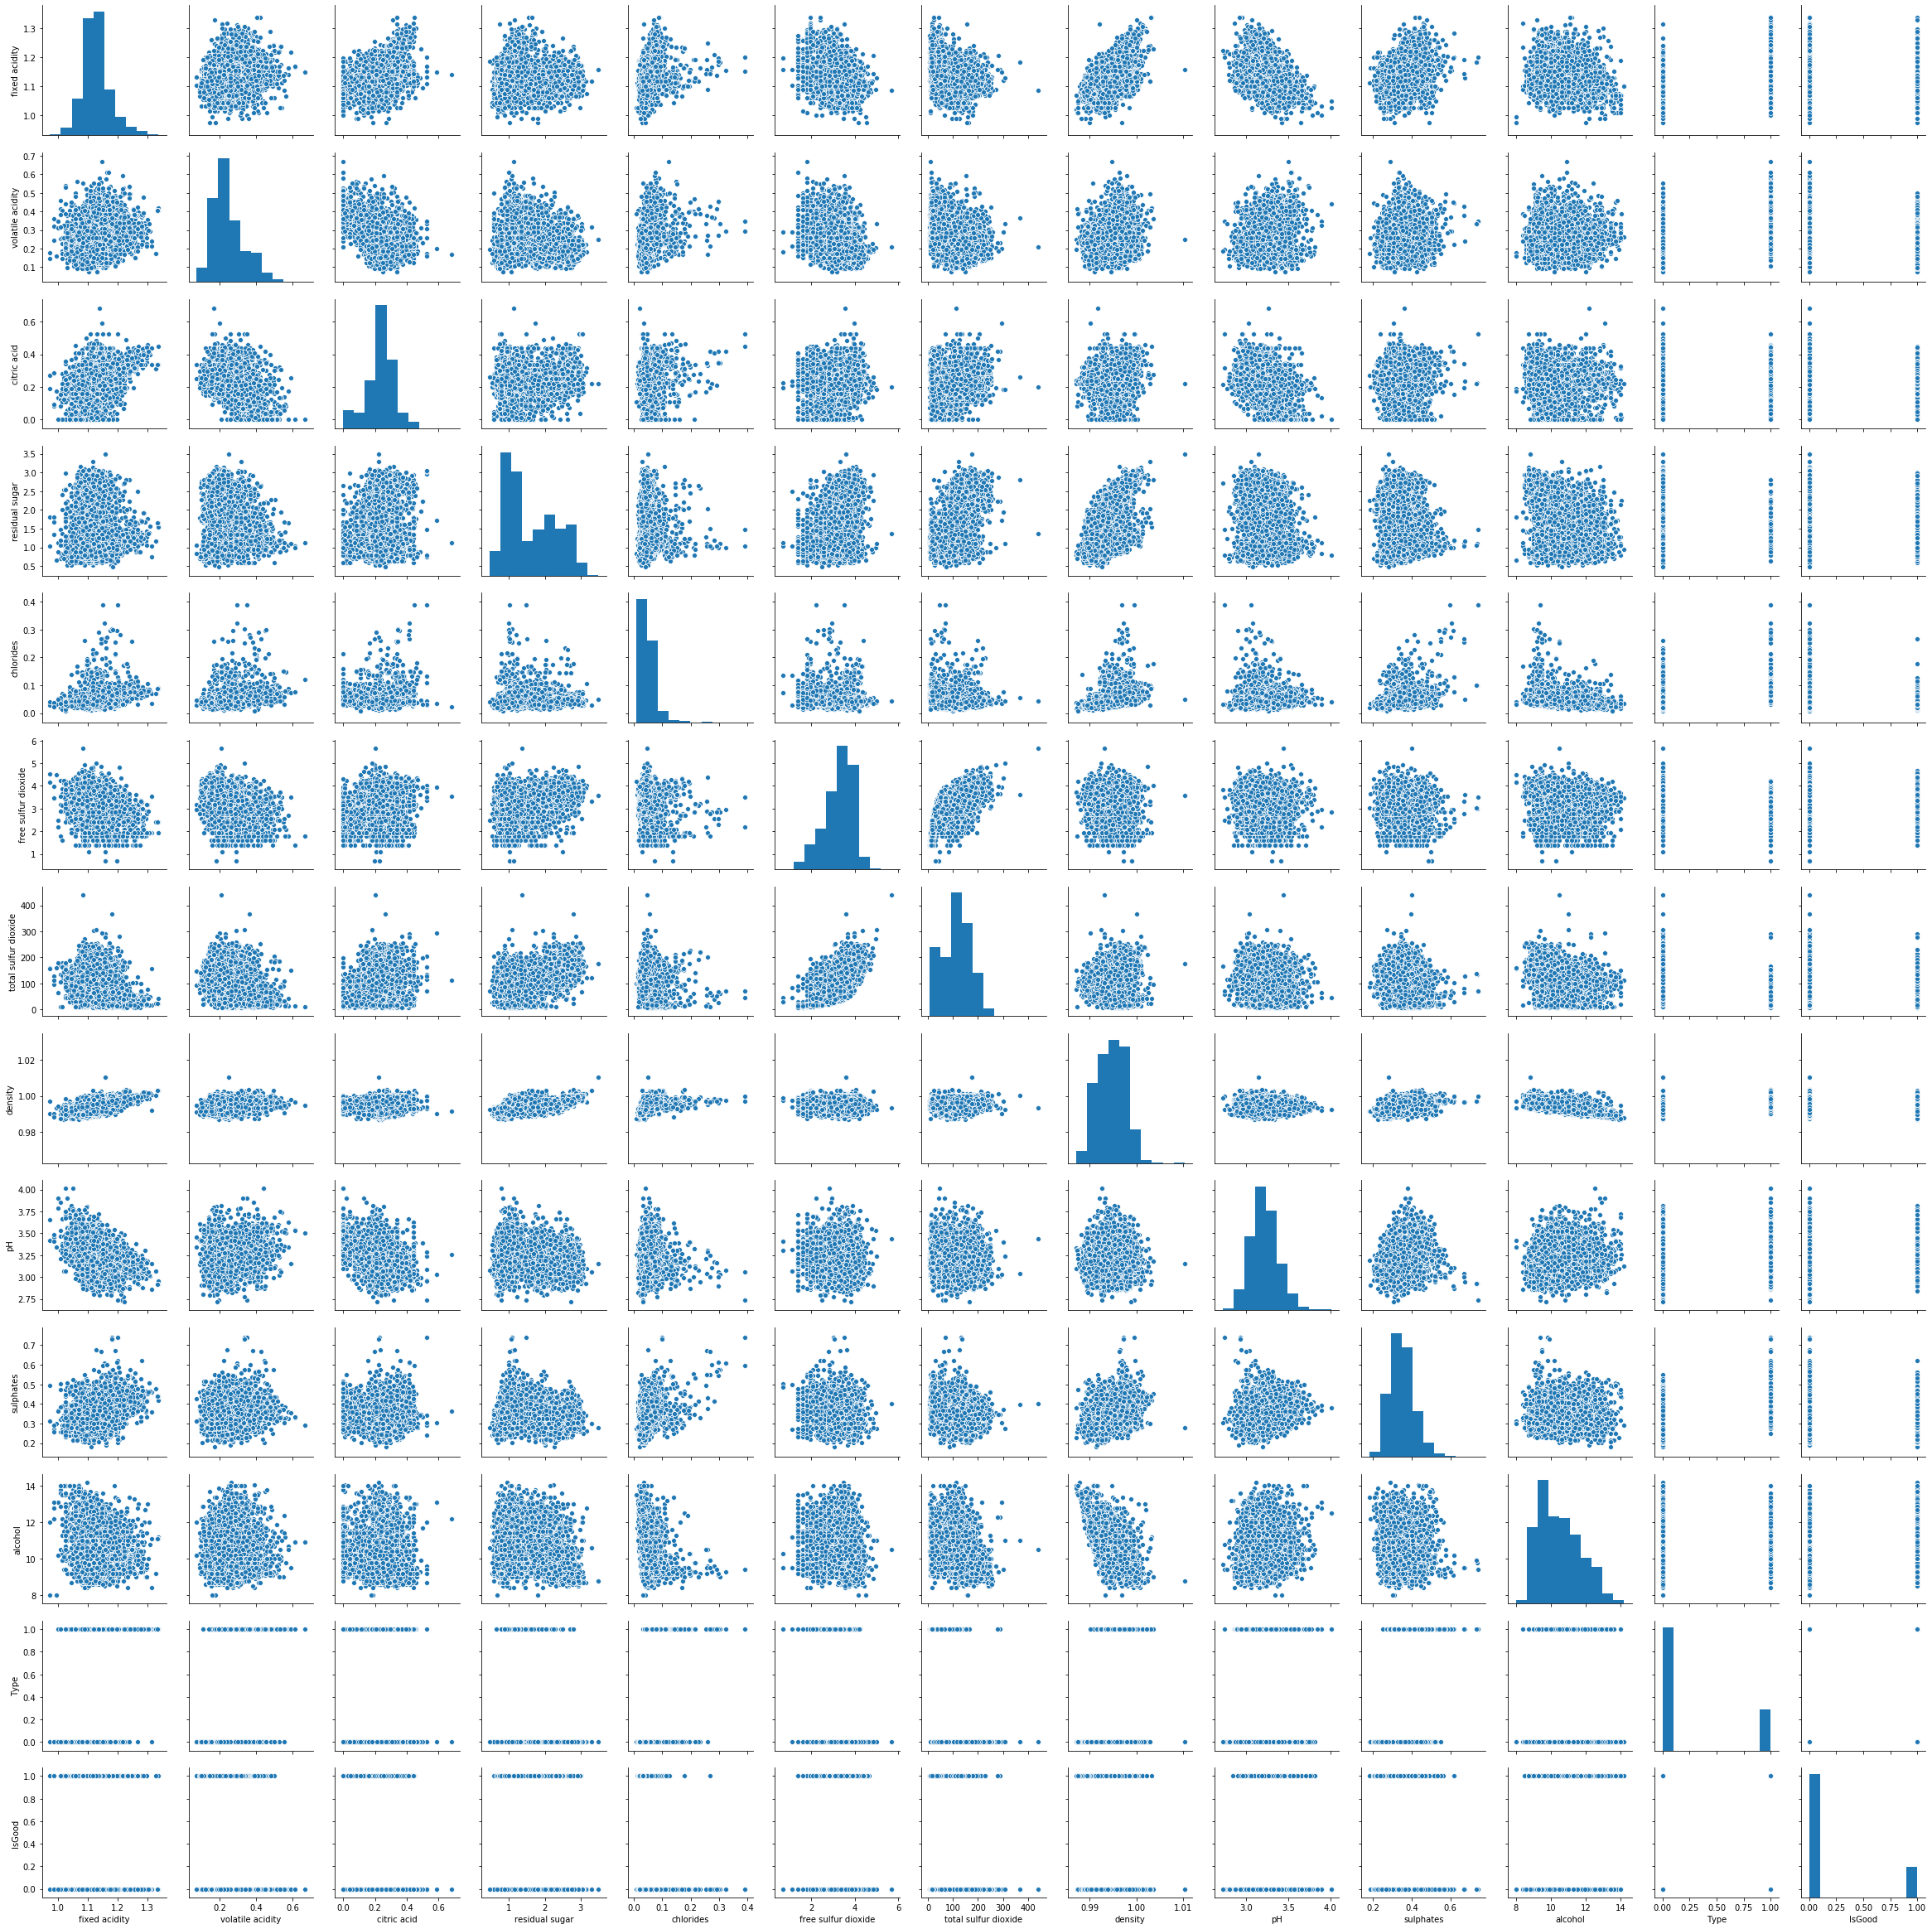

In [106]:
sns.pairplot(wine_train)

Разбиваем признаки на зависимые и не зависимые и делим выборку на две части: обучающую и тестовую.

In [81]:
X_train, y_train = wine_train.loc[:, wine_train.columns != 'IsGood'], wine_train['IsGood']
X_test, y_test = wine_test.loc[:, wine_test.columns != 'IsGood'], wine_test['IsGood']

In [82]:
# стандартизуем данные
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_transform = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_transform = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [83]:
X_train_transform.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Type
0,0.256087,0.230437,0.268177,0.546146,0.323698,0.634352,0.352535,0.348426,0.356589,0.222198,0.225806,0.0
1,0.720441,0.120989,0.400727,0.208542,0.611133,0.251724,0.027650,0.465286,0.449612,0.375258,0.403226,1.0
2,0.613568,0.204037,0.386820,0.141354,0.062619,0.737422,0.500000,0.314360,0.155039,0.199592,0.241935,0.0
3,0.218350,0.264718,0.299153,0.391020,0.035709,0.481821,0.163594,0.154807,0.534884,0.191954,0.629032,0.0
4,0.326936,0.120989,0.133931,0.403540,0.341826,0.580777,0.373272,0.295386,0.162791,0.191954,0.225806,0.0


### Feature selection и extraction.
#### Feature selection:
Уменьшает количество признаков. Выбор признаков с наибольшей «важностью» / влиянием на целевую переменную из набора существующих функций. Это может быть сделано с помощью различных методов: например, линейная регрессия, деревья решений.
#### Feature extraction: 
Добавляет признаки, которые вычисляются из других объектов, которые трудно анализировать напрямую / не сопоставим напрямую (например, изображения, временные ряды и т. Д.). В примере временного ряда могут быть использованы некоторые простые функции. пример: длина временного ряда, период, среднее значение, стандартное значение и т. д.
Для данного набора данных можно использовать PCA или полиномиальные фичи.  
Многие трюки с кодированием категориальных фичей в библиотеке https://github.com/scikit-learn-contrib/categorical-encoding


### Feature selection 
Для отбора наиболее информативных признаков воспользуемся критерием Хи-квадрат, F-критерием и информационным критерием и методом SelectKBest..

In [84]:
from sklearn.feature_selection import SelectKBest, SelectFdr
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
selector_kbest = SelectKBest()

In [107]:
?mutual_info_classif

## LogisticRegression
 class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False,tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1,class_weight=None, random_state=None, solver=’liblinear’,max_iter=100)
	
$!$ penalty: ’l1’, ’l2’(default = ’l2’),– вид регуляризации, “lbfgs”и “newton-cg” поддреживают только L2 регуляризвцию.

$!$ dual: bool(default = False), прямая или дуальная задача оптимизации. Дуальная формулировка поддерживается только с liblinear. Лучше использовать dual=False, когдаn_samples>n_features.

$!$ C: float(default=1.0)– параметр регуляризации, должен быть положительным float. Меньшее С обеспечивает более сильную регуляризацию.

$!$ fit_intercept : bool(default = True) – определяет добавлять ли константу к решающей функции.

$!$ intercept_scaling : float(default = 1) – полезен, только если используется libliner, если self.fit_intercept=True, то векторx, описывающий объект, становится равным [x,self.intercept_scaling].

$!$ class_weight :
dict or ‘balanced’(default=None)– веса, ассоциированные с классами, записываются в форме{class_label: weight}. Если параметр не указан, все веса предполагаются равными 1. ’balanced’ использует значения y, чтобы автоматически установить веса обратнопропорционально частотам класса во входных данных.

$!$ random_state: 
int seed, RandomState instance, or None(default) – для инициализации генератора псевдослучайных чисел при перемешивании данных.

$!$ solver : ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’(default =’liblinear’), – алгоритм, который используется для решения проблемы оптимизации.


$!$ max_iter : int(default=100) – используется только для newton-cg, sag и lbfgs. Максимальное число итераций.

$!$ multiclass: ’ovr’, ’multinimial’. При использовании ’ovr’ используется стратегия OneVsRest для мультиклассовойклассификации. Иначе, минимизируемая функция потерь это multinomial loss, которая учитывает полное распределение вероятностей.



### SelectKbest

https://habr.com/ru/post/264915/ - теория взята отсюда

### Informaition gain

Один из примеров методов фильтрации фич (filter methods) — informaition gain.  
Он тесно связан с понятием энтропии информации. Формулой энтропия выражается довольно просто:
$H(X)=-\sum_{x_{i}\in X}p(x_{i})*log_{2}(p(x_{i}))$

Где, $p(x_i)$ — вероятность того, что переменная X примет значение $x_i$. 

Для расчета корреляции между переменными нам понадобится определить еще несколько мер. 
Первая из них — specific conditional entropy:
$$H(Y|X=x_{i})$$  
— энтропия $H(Y)$ посчитанная только для тех записей, для которых $X=x_i$. 
Относительная энтропия (conditional entropy) считается как:
$$H(Y|X)=\sum_{x_{i}\in X}p(x_{i})*H(Y|X=x_{i})$$

Интересная такая величина не сама по себе, а ее разница с обычной энтропией фичи $Y$. Т.е. как бы мера того, насколько более упорядоченной становится для нас переменная $Y$, если мы знаем значения X. Или, говоря проще, существует ли корреляция между значениями $X$ и $Y$, и насколько она велика. Об этом говорит величина information gain:
$IG(Y|X)=H(Y)-H(Y|X)$

Чем больше параметр IG — тем сильнее корреляция. Таким образом, мы легко можем вычислить information gain для всех фич и выкинуть те, которые слабо влияют на целевую переменную. Тем самым, во-первых, сократив время расчета модели, а, во-вторых, уменьшив опасность переобучения.

### Хи-квадрат (chi-square)

Рассмотрим еще один популярный метод фильтрации фич, называемый chi-square test. Для того чтобы в нем разобраться понадобится вспомнить пару формул из теории вероятности. Первая из них это формула для вероятности пересечения (умножения) событий. Т.е. вероятность того, что произойдут оба события $A$ и $B$:
$$P(A\cap B)=P(A/B)*P(B)$$

Где $P(A/B)$ — вероятность того, что произойдет событие $A$, если $B$ уже наступило. Если эти события независимы (наступление одного из них никак не влияет на вероятность наступления другого), то:
$$P(A\cap B)=P(A)*P(B)$$

Исходя из этой формулы, можно посчитать ожидаемую вероятность наступления одновременно событий $A$ и $B$, если мы предполагаем, что они независимы. А затем вычислить, насколько реальность отличается от наших ожиданий. Формула хи-квадрат выглядит так:
$$\chi^{2}=\sum \frac{(observed - expected)^{2}}{expected}$$

In [108]:
?LogisticRegression

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight="balanced")

lr_selector = Pipeline([('selector', selector_kbest),
                      ('estimator', lr)])

parameters = {'selector__score_func': [chi2, f_classif, mutual_info_classif],
              'selector__k': list(range(10, 13)),
              'estimator__C':  10 ** np.linspace(-5, 2, 10), 
              'estimator__penalty': ['l1', 'l2'],
              'estimator__max_iter': [30, 70, 100]}

grid_search = GridSearchCV(lr_selector, parameters, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train_transform, y_train)
grid_search.best_score_, grid_search.best_params_

(0.8073369816284756,
 {'estimator__C': 100.0,
  'estimator__max_iter': 30,
  'estimator__penalty': 'l2',
  'selector__k': 11,
  'selector__score_func': <function sklearn.feature_selection.univariate_selection.chi2(X, y)>})

### RFE - Random Feature Elimination

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

lr = LogisticRegression(class_weight="balanced")
rfe = RFE(lr)
lr_selector = Pipeline([('selector', rfe),
                      ('estimator', lr)])

parameters = {'selector__n_features_to_select': list(range(7,13)),
              'estimator__C':  10 ** np.linspace(-5, 2, 10), 
              'estimator__penalty': ['l1', 'l2'],
              'estimator__max_iter': [70, 100]}

grid_search = GridSearchCV(lr_selector, parameters, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train_transform, y_train)
grid_search.best_score_, grid_search.best_params_

(0.8072505526729494,
 {'estimator__C': 100.0,
  'estimator__max_iter': 70,
  'estimator__penalty': 'l1',
  'selector__n_features_to_select': 12})

### VarianceThreeshold
https://habr.com/ru/company/ods/blog/325422/#statisticheskie-podhody  
Самый очевидный кандидат на отстрел – признак, у которого значение неизменно, т.е. не содержит вообще никакой информации. Если немного отойти от этого вырожденного случая, резонно предположить, что низковариативные признаки скорее хуже, чем высоковариативные. Так можно придти к идее отсекать признаки, дисперсия которых ниже определенной границы.

In [33]:
from sklearn.feature_selection import VarianceThreshold
lr = LogisticRegression(class_weight="balanced")
vt = VarianceThreshold()
lr_selector = Pipeline([('selector', vt),
                      ('estimator', lr)])

parameters = {'selector__threshold': [0.001, 0.005, 0.01, 0.05, 0.1],
              'estimator__C':  10 ** np.linspace(-5, 2, 10), 
              'estimator__penalty': ['l1', 'l2'],
              'estimator__max_iter': [70, 100]}

grid_search = GridSearchCV(lr_selector, parameters, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train_transform, y_train)
grid_search.best_score_, grid_search.best_params_

(0.8072505526729494,
 {'estimator__C': 100.0,
  'estimator__max_iter': 100,
  'estimator__penalty': 'l1',
  'selector__threshold': 0.001})

In [85]:
best_grid = {'estimator__C': 100.0,
  'estimator__max_iter': 70,
  'estimator__penalty': 'l1',
  'selector__n_features_to_select': 12}

In [87]:
from sklearn.model_selection import cross_validate
lr_selector = Pipeline([('selector', rfe),
                      ('estimator', lr)])
lr_selector.set_params(**best_grid)

Pipeline(memory=None,
         steps=[('selector',
                 RFE(estimator=LogisticRegression(C=1.0,
                                                  class_weight='balanced',
                                                  dual=False,
                                                  fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=None, max_iter=100,
                                                  multi_class='warn',
                                                  n_jobs=None, penalty='l2',
                                                  random_state=None,
                                                  solver='warn', tol=0.0001,
                                                  verbose=0, warm_start=False),
                     n_features_to_select=12, step=1, verbose=0)),
                ('estimator',
                 LogisticRegression(C=100.0, class_weight='balanc

In [88]:
cv_score = cross_validate(lr_selector, X_train, y_train, cv=StratifiedShuffleSplit(n_splits=5), scoring=['roc_auc',
                                                                                          'accuracy',
                                                                                          'f1',
                                                                                          'recall',
                                                                                          'precision'])
pd.DataFrame.from_dict(cv_score)

,fit_time,score_time,test_roc_auc,test_accuracy,test_f1,test_recall,test_precision
0,0.672287,0.009181,0.787128,0.705769,0.491694,0.725490,0.371859
1,1.512009,0.009397,0.808120,0.690385,0.492114,0.764706,0.362791
2,0.612732,0.009120,0.814195,0.717308,0.524272,0.794118,0.391304
3,0.698688,0.016572,0.789544,0.696154,0.483660,0.725490,0.362745
4,0.739475,0.010351,0.785909,0.717308,0.487805,0.686275,0.378378


In [89]:
cv_score_transform = cross_validate(lr_selector, X_train_transform, y_train, cv=StratifiedShuffleSplit(n_splits=5), scoring=['roc_auc',
                                                                                          'accuracy',
                                                                                          'f1',
                                                                                          'recall',
                                                                                          'precision'])
pd.DataFrame.from_dict(cv_score_transform)

,fit_time,score_time,test_roc_auc,test_accuracy,test_f1,test_recall,test_precision
0,0.191410,0.008125,0.823107,0.725000,0.548896,0.852941,0.404651
1,0.169847,0.008453,0.813561,0.692308,0.506173,0.803922,0.369369
2,0.175456,0.008297,0.862839,0.730769,0.565217,0.892157,0.413636
3,0.182081,0.008396,0.827681,0.709615,0.517572,0.794118,0.383886
4,0.182376,0.008531,0.760836,0.700000,0.469388,0.676471,0.359375


### Feature Extraction - полиномиальные фичи

In [90]:
from sklearn.preprocessing import PolynomialFeatures
pol = PolynomialFeatures(2)
pol.fit(X_train_transform)
X_train_transform_pol = pol.transform(X_train_transform)
X_test_transform_pol = pol.transform(X_test_transform)
cv_score_pol = cross_validate(lr_selector, X_train_transform, y_train, cv=StratifiedShuffleSplit(n_splits=5), scoring=['roc_auc',
                                                                                          'accuracy',
                                                                                          'f1',
                                                                                          'recall',
                                                                                          'precision'])
pd.DataFrame.from_dict(cv_score_pol)

,fit_time,score_time,test_roc_auc,test_accuracy,test_f1,test_recall,test_precision
0,0.180581,0.007989,0.807276,0.725000,0.521739,0.764706,0.395939
1,0.169544,0.008344,0.823576,0.732692,0.558730,0.862745,0.413146
2,0.168307,0.008385,0.810067,0.734615,0.520833,0.735294,0.403226
3,0.169642,0.009260,0.826836,0.742308,0.559211,0.833333,0.420792
4,0.179374,0.008670,0.782367,0.692308,0.477124,0.715686,0.357843


Видим, что на отдельных разбиениях показано более высокое качество, чем раньше

## протестируем на тестовой выборке

In [91]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

def LogReg(estimator, X_train, y_train, X_test, y_test, name):
    logreg = estimator
    logreg.fit(X_train, y_train)
    score_train = logreg.score(X_train, y_train)
    score_test = logreg.score(X_test, y_test)
    predictionsLOGIT = logreg.predict_proba(X_test)[:,1]
    roc_auc=roc_auc_score(y_test,predictionsLOGIT)
    data=pd.DataFrame((score_train,score_test,roc_auc), 
                 index = ['score_train','score_test','roc_auc'],columns = [name]) 
    return(data) 

In [93]:
LG_trans = LogReg(lr_selector, X_train, y_train, X_test, y_test, name='logreg')
LG_trans

,logreg
score_train,0.723109
score_test,0.737692
roc_auc,0.819654


In [92]:
LG = LogReg(lr_selector, X_train_transform, y_train, X_test_transform, y_test, name='logreg_transorm')
LG

,logreg_transorm
score_train,0.721185
score_test,0.737692
roc_auc,0.820185


In [109]:
LG_pol = LogReg(lr_selector, X_train_transform_pol, y_train, X_test_transform_pol, y_test, name='logreg_pol')
LG_pol

,logreg_pol
score_train,0.721570
score_test,0.747692
roc_auc,0.834961


In [95]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca.fit(X_train, y_train)
principalComponents_train = pca.fit_transform(X_train)
principalComponents_test = pca.fit_transform(X_test)
wine_train_pca_X = pd.DataFrame(data = principalComponents_train, columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6','PC7'])#
wine_train_pca = pd.concat([wine_train_pca_X, y_train], axis=1)

correlated_features = ['IsGood'] + list(wine_train_pca.corr().loc['IsGood'].abs().sort_values(ascending=False).iloc[1:11].index)
sub_df = wine_train_pca[correlated_features]
sub_df.corr().iloc[0,1:]

PC2    0.388931
PC3   -0.104664
PC7    0.097304
PC4   -0.061787
PC1   -0.050515
PC5   -0.029662
PC6   -0.027597
Name: IsGood, dtype: float64

По корреляции видим, что сильный вклад дают в основном 2 и 4 компоненты.

In [96]:
LG_pol = LogReg(lr_selector, principalComponents_train, y_train, principalComponents_test, y_test, name='logreg_pol')
LG_pol

,logreg_pol
score_train,0.726958
score_test,0.712308
roc_auc,0.762624


от главных компонент качество ухудшилось, лучшая комбинация у полиномиальных фич вместе с нормализацией

Видим, что в данном сл4учае классификаторы с отбором признаков методом и полиномиальными фичами имеют точность выше, чем если бы мы использовали PCA(Feature extraction).

### опционально смотрим на библиотеку для перекодирования

In [97]:
import category_encoders as ce
encoder = ce.TargetEncoder(cols=['Type'])

encoder.fit(X_train_transform, y_train)
X_cleaned_train = encoder.transform(X_train_transform)
X_cleaned_test = encoder.transform(X_test_transform)

In [98]:
LG_encode = LogReg(lr_selector, X_cleaned_train, y_train, X_cleaned_test, y_test, name='logreg_encode')
LG_encode

,logreg_encode
score_train,0.721185
score_test,0.737692
roc_auc,0.820174


In [110]:
pd.concat([LG, LG_pca, LG_pol, LG_trans, LG_encode], axis=1)

,logreg_transorm,logreg_pca,logreg_pol,logreg,logreg_encode
score_train,0.721185,0.725803,0.721570,0.723109,0.721185
score_test,0.737692,0.707692,0.747692,0.737692,0.737692
roc_auc,0.820185,0.696255,0.834961,0.819654,0.820174


#TODO: доверительный интвервал для Бернулли, t_test для зависимых выборок